In [1]:
#All Necessary import statements
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [20]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
# Note GENERATE_RES 4 or higher  
# may blow Google CoLab's memory
GENERATE_RES = 3 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/content/drive/My Drive/GAN'
EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 96px square images.


In [21]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [ ]:
# Image set has 11,682 images.  Can take over an hour 
# for initial preprocessing.
# Because of this time needed, save a Numpy preprocessed file.
# Note, that file is large enough to cause problems for 
# sume verisons of Pickle,
# so Numpy binary files are used.

# Now paths are joined with'/' directory separator
# F-strings provide a concise and convenient way to embed python expressions inside string literals for formatting.
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

# os.path.isfile() method in Python is used to check whether the specified path is an existing regular file or not.
if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  data_path = os.path.join(DATA_PATH,'images')

  # os.listdir method returns a list containing the names of the entries in the directory given by path.
  # tqdm Instantly make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable), and you’re done!
  # data path is whole path to images till now
  for filename in tqdm(os.listdir(data_path)):
      path = os.path.join(data_path,filename)
      # path is the name of image inside directory

      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      # The requested size in pixels, as a 2-tuple: (width, height).
      # here image is actual resized image 
      training_data.append(np.asarray(image))
      # Now training data has np array for first image
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  # This shapes the array to our desired GENERATE_SQUARE shape
  training_data = training_data.astype(np.float32)
  # Covert all values to float32
  training_data = training_data / 127.5 - 1.
  # It's like the purpose of this normalization is to bring the values in range [-1.0,1.0]


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  # resultant array is stored in a file with first argument as name with extention as npy which can be load using np.load()
  elapsed = time.time()-start
  # this would give total seconds passed till now
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) 
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    # .batch will take first BATCH_SIZE entries and make a batch out of them
    # .shuffle will allocate a buffer of our size for picking random entries. This buffer will be connected to the source dataset
    #  and this reading goes on until both buffer and source are empty
    #  TensorFlow Dataset object to actually hold the images. This allows the data to be quickly shuffled 
    #  and divide into the appropriate batch sizes for training. and shuffle and batch are methods used on that object with desired value

In [8]:
def build_generator(seed_size, channels):
    model = Sequential()
    # initialized a sequential model A Sequential model 
    # is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    # first layer with 4x4x256 neurons ( It is preferred to use 2 to the power number)  and range of all values in in lies within seed_size
    # ReLU stands for rectified linear unit, and is a type of activation function. Mathematically, it is defined as y = max(0, x).
    # generally if no idea relu is often prefered to be a starting function
    model.add(Reshape((4,4,256)))
    # This layer reshapes the input to particular shape

    model.add(UpSampling2D())
    # The generator model is typically implemented using a deep convolutional neural network 
    # and results-specialized layers that learn to fill in features in an image rather than extract features from an input image.
    # (UpSampling2D) simply doubles the dimensions of the input 
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    # 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.
    # kernel are preferrrably odd number integer (can be tuple (1,1)) because odd numbers are symmetric wrt to origin.
    # padding takes 2 values if "valid" means input volume is not zero padded and size can reduce if "same" it is padded
    model.add(BatchNormalization(momentum=0.8))
    # The general use case is to use BN between the linear and non-linear layers in your network, because it normalizes the input 
    # to your activation function, so that you're centered in the linear section of the activation function means of inputs =0 and sd=1. 
    model.add(Activation("relu"))
    # This activation layer does the non-linear transformation to the input making it capable to learn and perform more complex tasks.

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    # momentum for moving mean
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))
    # The advantage is that the negative inputs will be mapped strongly negative and 
    # the zero inputs will be mapped near zero in the tanh graph.

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    # Its default value is always set to (1, 1) which means that the given Conv2D filter is 
    # applied to the current location of the input volume and the given filter takes a 1-pixel step to the
    # right and again the filter is applied to the input volume and it is performed until we reach the far right border of
    # the volume in which we are moving our filter.
    model.add(LeakyReLU(alpha=0.2))
    # Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values
    # Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient. 0.01x

    model.add(Dropout(0.25))
    #  dropout and offers a very computationally cheap and remarkably effective regularization method 
    #  to reduce overfitting and improve generalization error in deep neural networks of all kinds.
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    # This layer can add rows and columns of given numbers at the top, bottom, left and right side of an image tensor.
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    #  As a rule of thumb, place the dropout after the activate function for all activation functions other than relu. 
    # In passing 0.5, every neuron is set to 0 with a probability of 0.5. In other words, there’s a 50% change 
    # that the output of a given neuron will be forced to 0.
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    # Flatten is used to flatten the input. For example, if flatten is applied to layer having input 
    # shape as (batch_size, 2,2), then the output shape of the layer will be (batch_size, 4)
    model.add(Dense(1, activation='sigmoid'))

    return model

In [9]:
# As we progress through training images will be produced to show the progress. These images will contain a number of rendered faces that 
# show how good the generator has become. These faces will be
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  # here the the matrix generated by rows and columns are filled with value 255 where matrix has margins to accomodate multiple images
  
  generated_images = generator.predict(noise)
  # this will come later

  generated_images = 0.5 * generated_images + 0.5
  # normalized images are generated and stored in an np array

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] 
            = generated_images[image_count] * 255
        # this image is loaded into our image_Array genetrated first 
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  # Then this can be used to convert it to a Pillow image from np array
  im.save(filename)
  # image is saved in filename location

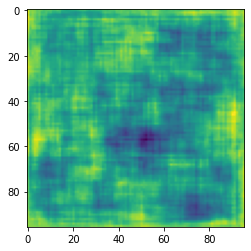

In [11]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)
# this is passed to model above
# generator is our main generator model
noise = tf.random.normal([1, SEED_SIZE])
# shape means number of rows and first arg here is shape and SEED_SIZE is the range from where values should be picked
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])
# So when you use, im[:, :, 0], it would write the first channel. Therefore you will get a grayscale image. and here from the matrix we 
# print first image

In [2]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)
# declare an image 
discriminator = build_discriminator(image_shape)
# pass that to the discriminator and return the model
decision = discriminator(generated_image)
# pass generator generated images to descriminator
print (decision)

NameError: ignored

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# It is a Sigmoid activation plus a Cross-Entropy loss. Unlike Softmax loss it is independent for each vector component 
# (class), meaning that the loss computed for every CNN output vector component is not affected by other component values.
# so this is basically logistic so loss evaluated is log loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
# Optimizer that implements the Adam algorithm.
# Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure 
# to update network weights iterative based in training data ( adaptive moment estimation.)
# Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate 
# does not change during training. while for adam A learning rate is maintained for each network weight (parameter) 
# and separately adapted as learning unfolds.
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
# two learning rates

In [15]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # gradient tape cause simulataneous training yet separate training
    # Record operations for automatic differentiation.
    # why two tapes? The technical reason is that gradient is called twice, which is not allowed on (non-persistent) tapes.
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    # the underlying reason is that training of GANS is typically done by alternating the optimization of the generator and the discriminator
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    # trainable variables are all those variables whose value changes due to 
    # During training, an optimizer gets the content of that collection via tf.trainable_variables() and applies the training to all of them.
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [16]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  # picks value from normal distribution with first arg as mean=0 and second arg as SD=1
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      # return both lossses and the below store them in different lists
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')


In [17]:
train(train_dataset, EPOCHS)

Epoch 1, gen loss=0.6710952520370483,disc loss=1.2710381746292114, {hms_string(epoch_elapsed)}
Epoch 2, gen loss=0.6745414137840271,disc loss=1.246140956878662, {hms_string(epoch_elapsed)}
Epoch 3, gen loss=0.6781510710716248,disc loss=1.22182297706604, {hms_string(epoch_elapsed)}
Epoch 4, gen loss=0.6796154379844666,disc loss=1.2195924520492554, {hms_string(epoch_elapsed)}
Epoch 5, gen loss=0.6831667423248291,disc loss=1.2065032720565796, {hms_string(epoch_elapsed)}
Epoch 6, gen loss=0.6847158074378967,disc loss=1.2020518779754639, {hms_string(epoch_elapsed)}
Epoch 7, gen loss=0.6792387366294861,disc loss=1.1611942052841187, {hms_string(epoch_elapsed)}
Epoch 8, gen loss=0.663709819316864,disc loss=1.1599644422531128, {hms_string(epoch_elapsed)}
Epoch 9, gen loss=0.6903338432312012,disc loss=1.0163854360580444, {hms_string(epoch_elapsed)}
Epoch 10, gen loss=0.6753270030021667,disc loss=1.0947086811065674, {hms_string(epoch_elapsed)}
Epoch 11, gen loss=0.6909915208816528,disc loss=1.013

In [19]:
generator.save(os.path.join(DATA_PATH,"face_generator.h5"))

array([-0.2235294, -0.5921569, -0.8117647], dtype=float32)